In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['__output__.json', 'train_features.csv', 'y_train.csv', '__notebook__.ipynb', '__results__.html', 'custom.css', 'test_features.csv']


In [2]:
%%time
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tqdm_gui

from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
pd.options.display.precision = 15

%matplotlib inline
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import time
import datetime
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

import tsfresh
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

print('MODULES IMPORTED')

MODULES IMPORTED
CPU times: user 660 ms, sys: 136 ms, total: 796 ms
Wall time: 1.48 s


**FEATURES EXTRACTION**

In [3]:
X_train_scaled = pd.read_csv('../input/train_features.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test_scaled = pd.read_csv('../input/test_features.csv')

In [4]:
print(X_train_scaled.head())
print(y_train.head())
print(X_test_scaled.head())

                 sum        ...          number_crossing_m
0  1.424140499795018        ...         -0.830008218154674
1  0.805716032556438        ...         -0.522762630966185
2  1.511155259373636        ...         -0.674061008151163
3  1.494934375107485        ...         -0.960598158238914
4  1.520242078970566        ...         -1.062027237915994

[5 rows x 156 columns]
     time_to_failure
0  1.430797219276428
1  1.391498923301697
2  1.353196144104004
3  1.313797831535339
4  1.274399518966675
                 sum        ...          number_crossing_m
0  1.360262645399912        ...         -0.827029908781083
1  0.089336994250242        ...          0.025584614802652
2  1.829903155073301        ...         -1.724237242175683
3  1.517602257969987        ...         -2.083655289251253
4 -0.080369924111366        ...         -0.003846639672519

[5 rows x 156 columns]


In [5]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [6]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_train, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'lasso':
            model = LassoCV(**params, n_jobs = -1)
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            y_pred = model.predict(X_test)
            
        if model_type == 'xgb':
            model = XGBRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
    
        
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        
        if True:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            if model_type == 'lasso':
                fold_importance["importance"] = model.coef_
            else :
                fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
        

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title(model_type+' Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

**LG BOOST**

Fold 0 started at Fri May 10 07:53:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1271]	training's l1: 1.53527	valid_1's l1: 2.06098
Fold 1 started at Fri May 10 07:53:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1324]	training's l1: 1.52129	valid_1's l1: 2.0191
Fold 2 started at Fri May 10 07:54:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1210]	training's l1: 1.5423	valid_1's l1: 2.12343
Fold 3 started at Fri May 10 07:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[948]	training's l1: 1.70047	valid_1's l1: 1.91364
Fold 4 started at Fri May 10 07:54:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1032]	training's l1: 1.63614	valid_1's l1: 2.06646
CV mean score: 2.0367, std: 0.0699.


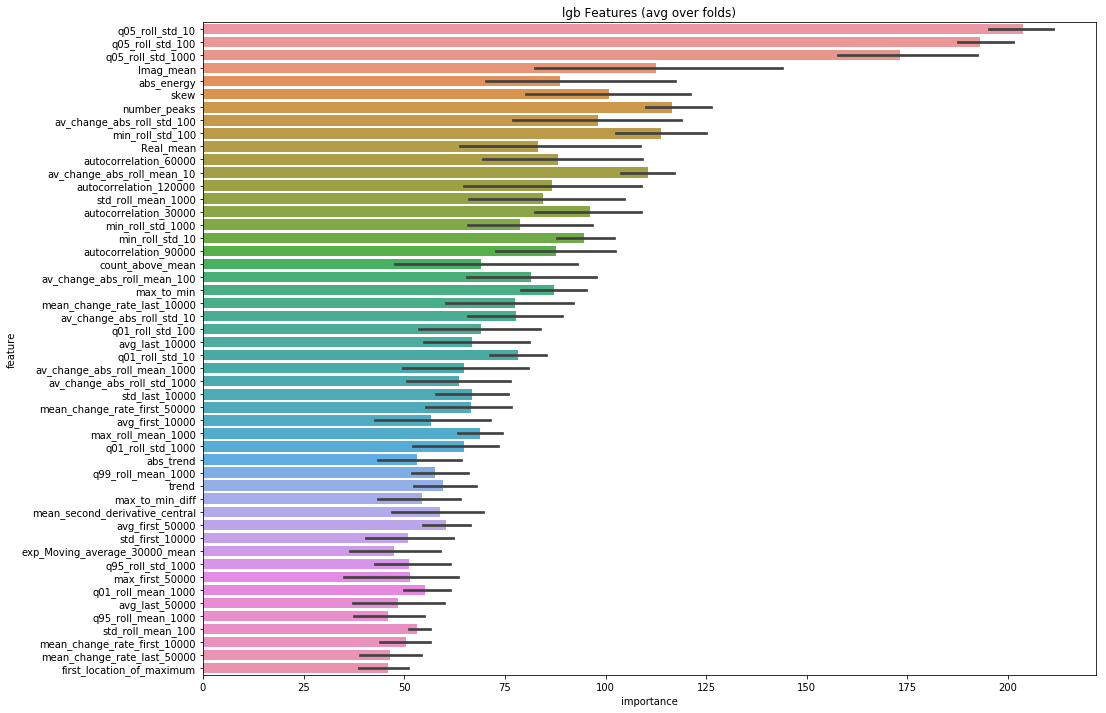

In [7]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance_lgb = train_model(params=params, model_type='lgb', plot_feature_importance=True)

**XG BOOST**

Fold 0 started at Fri May 10 07:54:51 2019
[0]	validation_0-mae:4.69707	validation_1-mae:4.84787
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[35]	validation_0-mae:0.723932	validation_1-mae:2.16633

Fold 1 started at Fri May 10 07:55:11 2019
[0]	validation_0-mae:4.72174	validation_1-mae:4.74718
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[31]	validation_0-mae:0.783986	validation_1-mae:2.07812

Fold 2 started at Fri May 10 07:55:28 2019
[0]	validation_0-mae:4.72076	validation_1-mae:4.779
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[63]	validation_0-mae:0.401576	validation_1-m

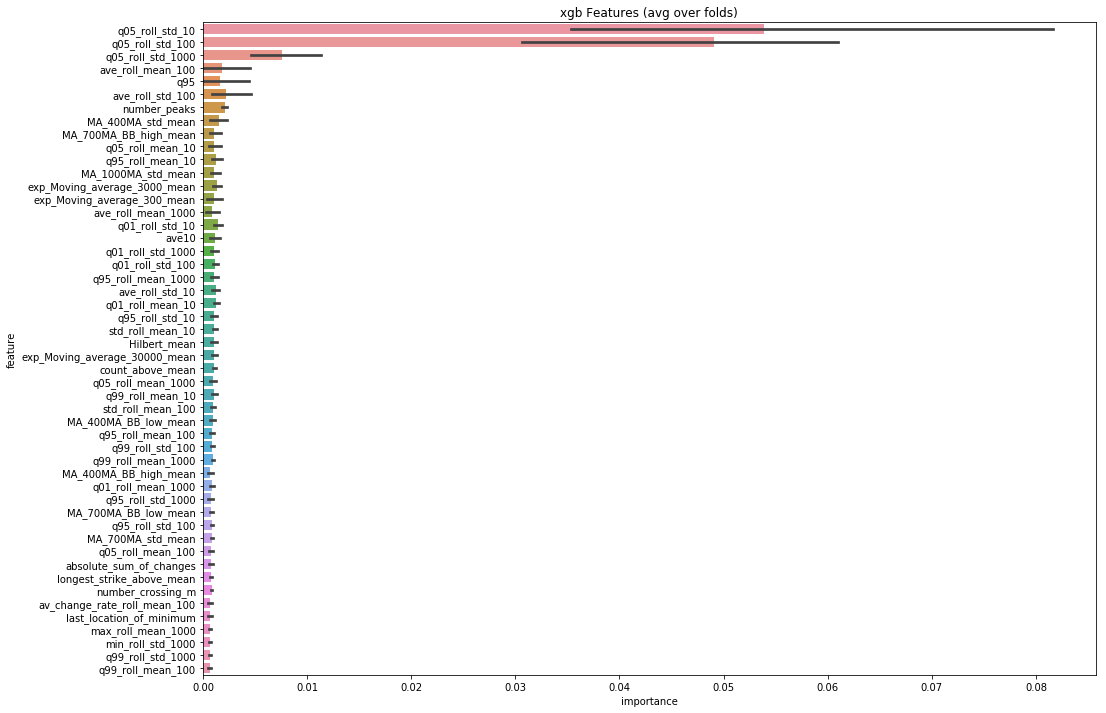

In [8]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb, feature_importance_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb', plot_feature_importance=True)

**LASSO CV**

Fold 0 started at Fri May 10 07:56:24 2019
Fold 0. MAE: 2.1603.

Fold 1 started at Fri May 10 07:56:27 2019
Fold 1. MAE: 2.0865.

Fold 2 started at Fri May 10 07:56:29 2019
Fold 2. MAE: 2.2135.

Fold 3 started at Fri May 10 07:56:31 2019
Fold 3. MAE: 1.9680.

Fold 4 started at Fri May 10 07:56:33 2019
Fold 4. MAE: 2.1887.

CV mean score: 2.1234, std: 0.0886.


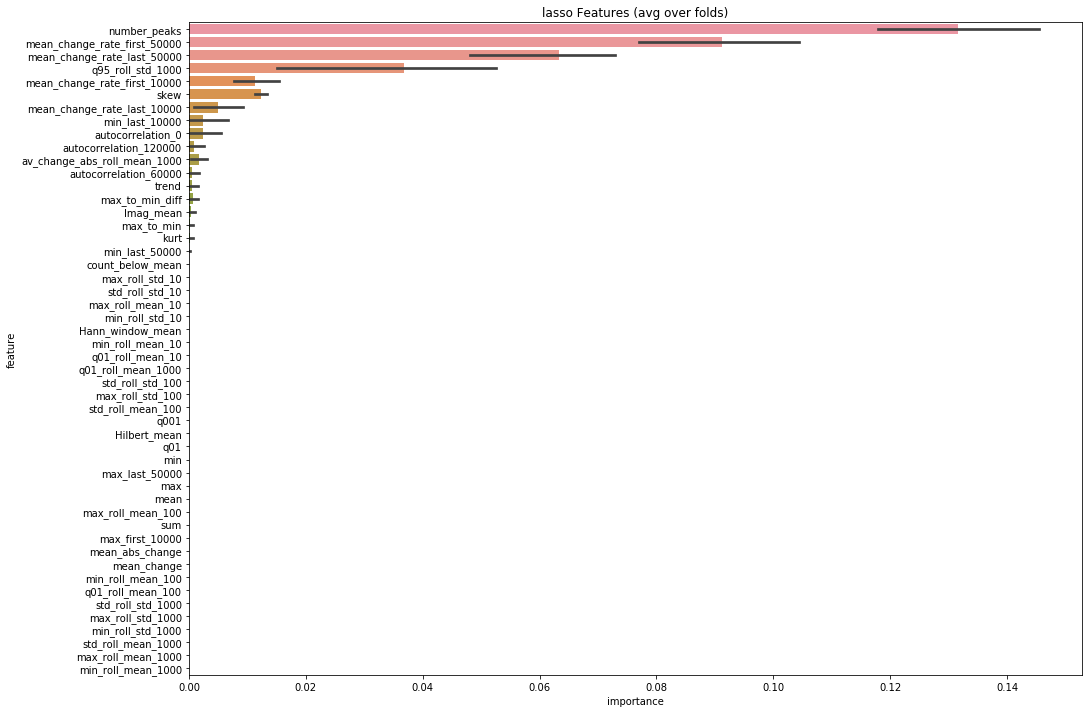

In [9]:
params = {'cv':5}
oof_lasso, prediction_lasso, feature_importance_lasso = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='lasso', plot_feature_importance=True)

In [10]:
feature_importance_lgb.groupby(["feature"])["importance"].mean().to_csv("lgb_importance.csv")
feature_importance_xgb.groupby(["feature"])["importance"].mean().to_csv("xgb_importance.csv")
feature_importance_lasso.groupby(["feature"])["importance"].mean().to_csv("lasso_importance.csv")